Processing audio files...
Processing /content/drive/MyDrive/Colab Notebooks/piping_database/FinalDataSet/2022-06-05--17-41-01_2__segment0.wav...
Processing /content/drive/MyDrive/Colab Notebooks/piping_database/FinalDataSet/2022-06-05--17-41-01_2__segment5.wav...
Processing /content/drive/MyDrive/Colab Notebooks/piping_database/FinalDataSet/2022-06-05--17-41-01_2__segment2.wav...
Processing /content/drive/MyDrive/Colab Notebooks/piping_database/FinalDataSet/2022-06-05--18-40-08_2__segment2.wav...
Processing /content/drive/MyDrive/Colab Notebooks/piping_database/FinalDataSet/2022-06-05--17-41-01_2__segment4.wav...
Processing /content/drive/MyDrive/Colab Notebooks/piping_database/FinalDataSet/2022-06-05--19-39-14_2__segment0.wav...
Processing /content/drive/MyDrive/Colab Notebooks/piping_database/FinalDataSet/2022-06-05--18-40-08_2__segment0.wav...
Processing /content/drive/MyDrive/Colab Notebooks/piping_database/FinalDataSet/2022-06-05--18-40-08_2__segment5.wav...
Processing /content/dr

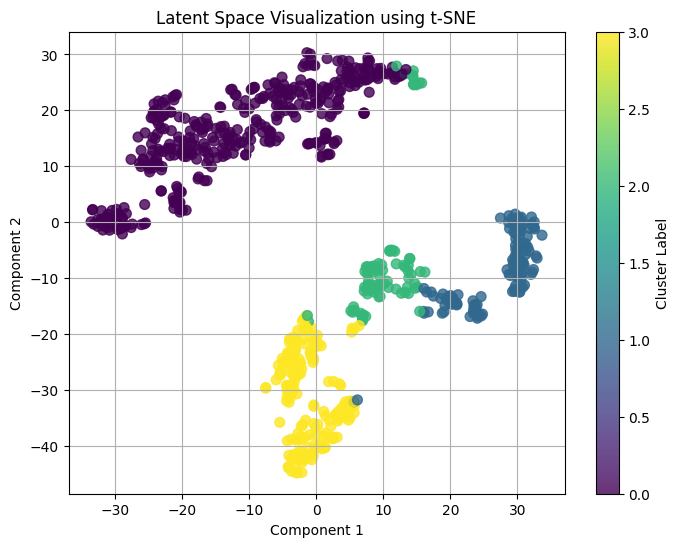

Visualizing latent space with UMAP...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


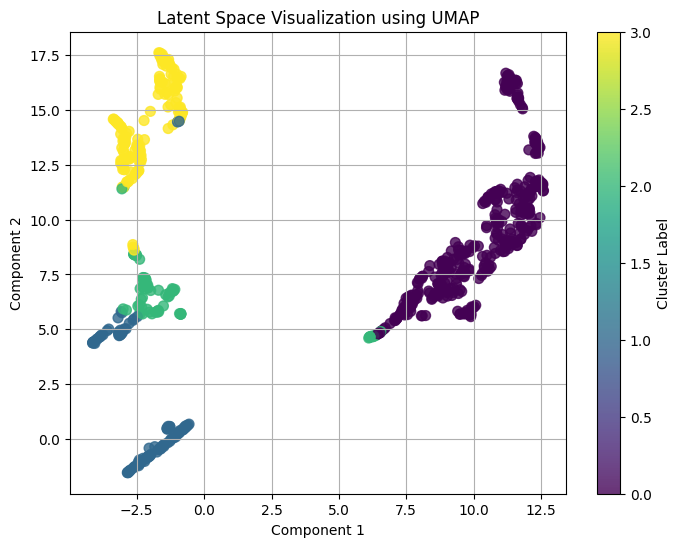

MAE Loss - Silhouette Score: 0.4625
MAE Loss - Davies-Bouldin Index: 0.8593
Visualizing latent space with t-SNE...


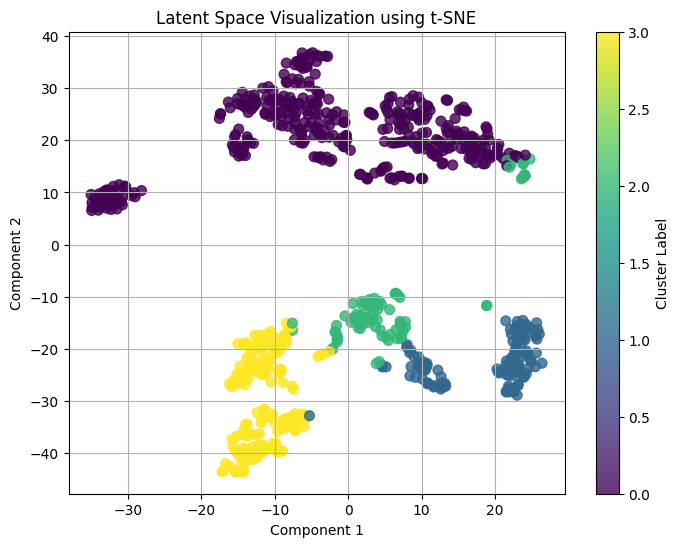

Visualizing latent space with UMAP...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


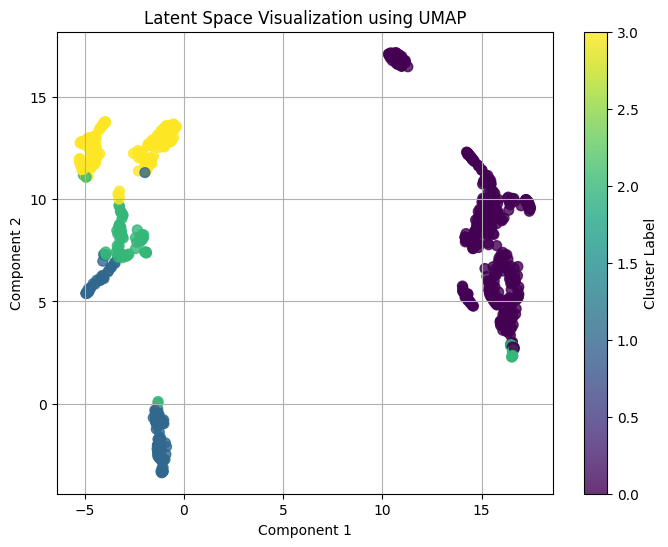

In [ ]:
import os
import glob
import numpy as np
import librosaa
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from umap import UMAP # if this gives issues, try this: import umap.umap_ as UMAP
import matplotlib.pyplot as plt
from scipy.signal import welch
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError

# Directory paths
audio_dir = "/content/drive/MyDrive/Colab Notebooks/piping_database/FinalDataSet/"
output_csv = "/content/drive/MyDrive/Colab Notebooks/piping_database/bee_sound_Cluster_labels.csv"

# Label Mapping
label_mapping = {
    0: ("Normal", "Not Stressed"),
    1: ("MissingQueenBee", "Stressed"),
    2: ("Swarming", "Stressed"),
    3: ("Hyper", "Stressed")
}

# Function to extract enhanced audio features
# Enhanced Function to extract audio features
def extract_audio_features(file_path):
    try:
        y, sr = librosa.load(file_path, sr=None)

        # MFCCs
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfcc_mean = np.mean(mfcc, axis=1)

        # Spectral Features
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr).mean()
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr).mean()
        spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr).mean()
        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.85).mean()

        # Temporal Features
        zero_crossing_rate = librosa.feature.zero_crossing_rate(y).mean()
        rms = librosa.feature.rms(y=y).mean()

        # RMS Energy in dB

        amplitude_db = 20 * np.log10(rms) if rms > 0 else -np.inf

        # Dominant Frequency (STFT)
        stft = np.abs(librosa.stft(y))
        frequencies = librosa.fft_frequencies(sr=sr)
        dominant_frequency = frequencies[np.argmax(np.sum(stft, axis=1))]

        ##############################################
        # PSD Features with Specific Frequency Bands
        freqs, psd = welch(y, fs=sr, nperseg=1024)
        band_definitions = [
            (300, 500),  # Tooting
            (300, 350),  # Quacking
            (300, 3600), # Hissing
            (100, 2000), # Piping
            (200, 350)   # Recruit
        ]
        psd_band_energy = [np.sum(psd[(freqs >= band[0]) & (freqs <= band[1])]) for band in band_definitions]

        # Additional Features


        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        chroma_mean = np.mean(chroma, axis=1)
        zero_crossings = librosa.feature.zero_crossing_rate(y=y).mean()
        ##############################################


        # Combine features
        return np.hstack([
            mfcc_mean,
            *psd_band_energy,
            spectral_bandwidth,
            spectral_contrast,
            rms,
            amplitude_db,
            dominant_frequency

        ])
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


# Process audio files with enhanced feature extraction
def process_audio_files(audio_dir):
    features = []
    file_names = []
    for file_path in glob.glob(f"{audio_dir}/**/*.*", recursive=True):
        if file_path.lower().endswith(('.wav', '.mp3')):
            print(f"Processing {file_path}...")
            feature_vector = extract_audio_features(file_path)
            if feature_vector is not None:
                features.append(feature_vector)
                file_names.append(os.path.basename(file_path))
    return np.array(features), file_names

# Build an autoencoder with larger latent space
def build_autoencoder(input_dim, encoding_dim, loss_function):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(encoding_dim, activation='relu')(input_layer)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)

    autoencoder = Model(input_layer, decoded)
    encoder = Model(input_layer, encoded)
    autoencoder.compile(optimizer='adam', loss=loss_function)
    return autoencoder, encoder

# Dimensionality reduction with t-SNE and UMAP
def visualize_latent_space(latent_space, labels, method='t-SNE'):
    if method == 't-SNE':
        reducer = TSNE(n_components=2, random_state=42)
    elif method == 'UMAP':
        reducer = UMAP(n_components=2, random_state=42)
    else:
        raise ValueError("Unsupported method. Choose 't-SNE' or 'UMAP'.")

    latent_2d = reducer.fit_transform(latent_space)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='viridis', s=50, alpha=0.8)
    plt.colorbar(scatter, label='Cluster Label')
    plt.title(f"Latent Space Visualization using {method}")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)
    plt.show()

# Compare clustering results for different loss functions
def compare_loss_functions(features, n_clusters=4, encoding_dim=20):
    scaler = MinMaxScaler()
    features_scaled = scaler.fit_transform(features)

    input_dim = features_scaled.shape[1]
    loss_functions = {
        'MSE': MeanSquaredError(),
        'MAE': MeanAbsoluteError()
    }

    results = {}

    for name, loss_function in loss_functions.items():
        print(f"Training autoencoder with {name} loss...")
        autoencoder, encoder = build_autoencoder(input_dim, encoding_dim, loss_function)
        autoencoder.fit(features_scaled, features_scaled, epochs=50, batch_size=32, shuffle=True, verbose=0)

        latent_features = encoder.predict(features_scaled)
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(latent_features)
        silhouette_avg = silhouette_score(latent_features, cluster_labels)
        davies_bouldin_avg = davies_bouldin_score(latent_features, cluster_labels)

        results[name] = {
            'latent_features': latent_features,
            'cluster_labels': cluster_labels,
            'silhouette_score': silhouette_avg,
            'davies_bouldin_index': davies_bouldin_avg
        }

    return results

# Main workflow
def main():
    audio_dir = "/content/drive/MyDrive/Colab Notebooks/piping_database/FinalDataSet/"  # Update with the actual directory path
    print("Processing audio files...")
    features, file_names = process_audio_files(audio_dir)

    if features.size > 0:
        results = compare_loss_functions(features, n_clusters=4, encoding_dim=20)

        for name, result in results.items():
            print(f"{name} Loss - Silhouette Score: {result['silhouette_score']:.4f}")
            print(f"{name} Loss - Davies-Bouldin Index: {result['davies_bouldin_index']:.4f}")
            print("Visualizing latent space with t-SNE...")
            visualize_latent_space(result['latent_features'], result['cluster_labels'], method='t-SNE')

            print("Visualizing latent space with UMAP...")
            visualize_latent_space(result['latent_features'], result['cluster_labels'], method='UMAP')
    else:
        print("No valid audio files processed.")

if __name__ == "__main__":
    main()


In [ ]:
pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 2.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

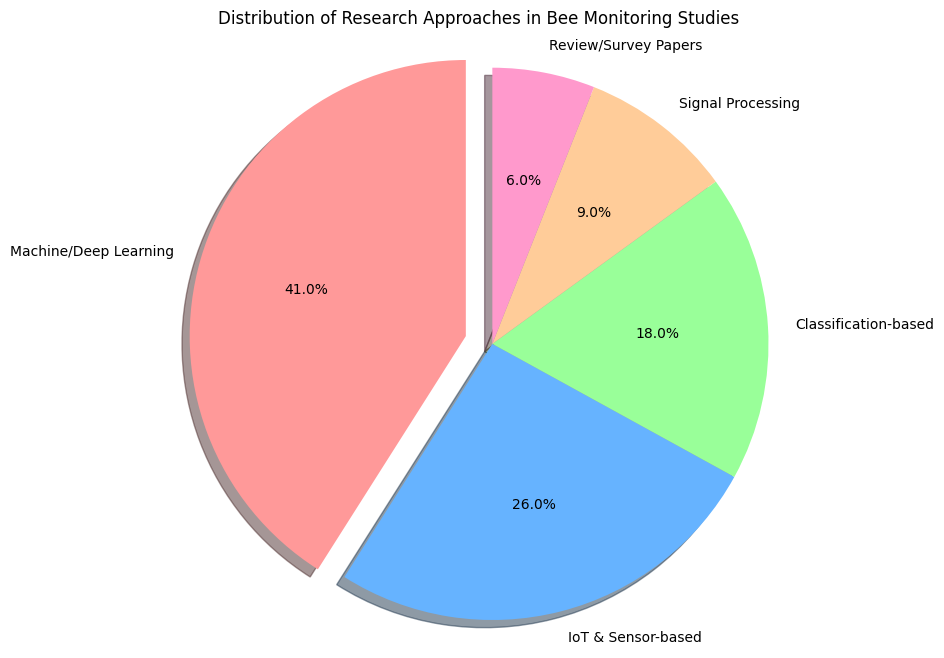

In [ ]:
import matplotlib.pyplot as plt

# Data for pie chart
categories = ['Machine/Deep Learning', 'IoT & Sensor-based',
              'Classification-based', 'Signal Processing', 'Review/Survey Papers']
sizes = [41, 26, 18, 9, 6]
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#ff99cc']
explode = (0.1, 0, 0, 0, 0)  # explode 1st slice

plt.figure(figsize=(10, 8))
plt.pie(sizes, explode=explode, labels=categories, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')
plt.title('Distribution of Research Approaches in Bee Monitoring Studies')
plt.show()

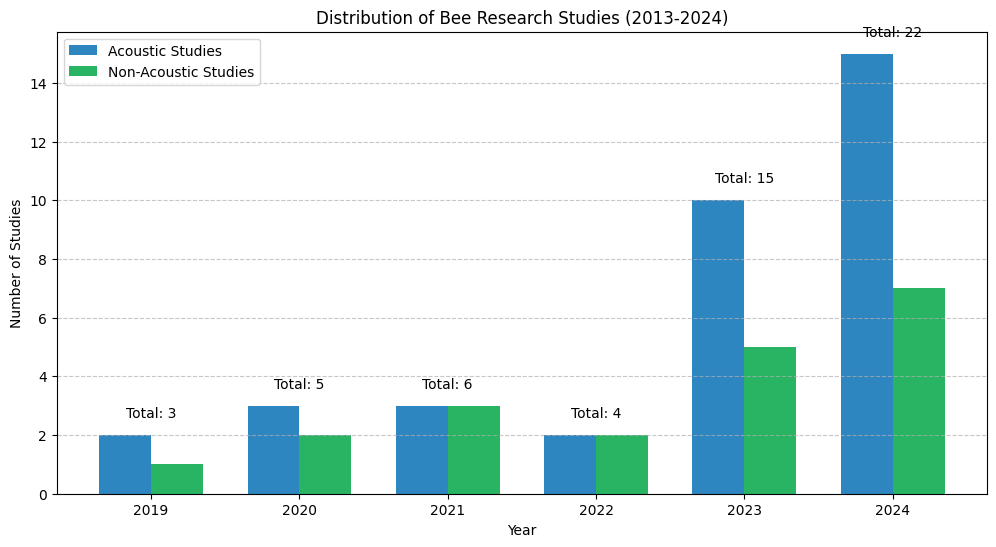

In [1]:
import matplotlib.pyplot as plt
import numpy as np

years = [ 2019, 2020, 2021, 2022, 2023, 2024]
acoustic = [ 2, 3, 3, 2, 10, 15]
non_acoustic = [ 1, 2, 3, 2, 5, 7]

width = 0.35
# Use plt.subplots() to get the figure and axes objects
fig, ax = plt.subplots(figsize=(12, 6))

# Now 'ax' can be used for plotting
ax.bar(np.array(years) - width/2, acoustic, width, label='Acoustic Studies', color='#2E86C1')
ax.bar(np.array(years) + width/2, non_acoustic, width, label='Non-Acoustic Studies', color='#28B463')

plt.title('Distribution of Bee Research Studies (2013-2024)')
plt.xlabel('Year')
plt.ylabel('Number of Studies')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add total values on top of each year
for i in range(len(years)):
    total = acoustic[i] + non_acoustic[i]
    plt.text(years[i], max(acoustic[i], non_acoustic[i]) + 0.5, f'Total: {total}',
             ha='center', va='bottom')